# Skenario 1: Fine-Tuning (Perbandingan BERT, RoBERTa, IndoBERTweet)

Notebook ini menjalankan skenario pertama dari penelitian transfer learning: **standard fine-tuning**.

**Tujuan:**
- Melatih tiga model pretrained (BERT Multilingual, RoBERTa, dan IndoBERTweet) pada dataset klasifikasi sentimen.
- Membandingkan performa mereka berdasarkan metrik standar (Loss, Accuracy, Precision, Recall, F1-Score).
- Visualisasikan riwayat training dan validasi untuk setiap metrik dalam plot perbandingan.

# Import Libraries

In [1]:
%%capture
%pip install --upgrade ipywidgets
%pip install --upgrade jupyter

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torch.optim import AdamW  

from transformers import (
    AutoTokenizer, 
    AutoConfig, 
    AutoModelForSequenceClassification, 
    get_linear_schedule_with_warmup
)

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from transformers import logging
import seaborn as sns
import warnings
import time
import gc

logging.set_verbosity_error()
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
sns.set_theme(style="whitegrid", palette="muted")
plt.style.use('default')

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan perangkat: {DEVICE}")

MODEL_CONFIGS = {
    "IndoBERTbase": "indobenchmark/indobert-base-p1",
    "IndoBERTweet": "indolem/indobertweet-base-uncased",
    "RoBERTa": "databoks-irfan/twitter-comment-roberta-base-indonesian-smsa"
}

# Hyperparameters
RANDOM_STATE = 42
MAX_LEN = 128
BATCH_SIZE = 16
N_SPLITS = 3
EPOCHS = 4
LEARNING_RATES_TO_TEST = [5e-5, 3e-5, 2e-5, 1e-5]
WEIGHT_DECAY = 0.01
DROPOUT_RATE = 0.2

DATA_PATH = '../data/pemilu_data_preprocesed.csv' 

Menggunakan perangkat: cuda


In [4]:
class SentimentDataset(Dataset):
    """Dataset class untuk sentimen."""
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx]); label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            return_token_type_ids=False, padding='max_length',
            truncation=True, return_attention_mask=True, return_tensors='pt',)
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [5]:
def load_data(path):
    """Memuat data dari CSV dan mengembalikan teks dan label."""
    df = pd.read_csv(path)
    label_map = {"neutral": 0, "positive": 1, "negative": 2}
    df['label'] = df['sentiment'].map(label_map)
    df.dropna(subset=['label'], inplace=True)
    df['label'] = df['label'].astype(int)

    print(f"Data berhasil dimuat. Total sampel: {len(df)}")
    return df['text'].tolist(), df['label'].tolist(), len(label_map)

all_texts, all_labels, num_labels = load_data(DATA_PATH)

Data berhasil dimuat. Total sampel: 22205


In [6]:
def compute_metrics(labels, preds):
    """Menghitung metrik evaluasi."""
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average='weighted', zero_division=0),
        "recall": recall_score(labels, preds, average='weighted', zero_division=0),
        "f1": f1_score(labels, preds, average='weighted', zero_division=0)
    }

In [7]:
def average_histories(histories):
    """Merata-ratakan riwayat dari beberapa fold."""
    if not histories:
        return {}
    
    avg_history = {}
    # Ambil semua key dari histori pertama (asumsi semua sama)
    metric_keys = histories[0].keys()
    # Dapatkan jumlah epoch maksimum dari semua fold
    max_epochs = max(len(h['train_loss']) for h in histories)

    for key in metric_keys:
        # Kumpulkan nilai metrik dari semua fold, pad dengan NaN jika epoch lebih sedikit
        padded_values = [h[key] + [np.nan] * (max_epochs - len(h[key])) for h in histories]
        avg_history[key] = np.nanmean(padded_values, axis=0)
        
    return avg_history

In [8]:
def train_epoch(model, data_loader, optimizer, device, scaler, scheduler):
    """Satu epoch training."""
    model.train()
    total_loss, all_preds, all_labels = 0, [], []
    
    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        with autocast(device_type=device.type, dtype=torch.float16):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        all_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    metrics = compute_metrics(all_labels, all_preds)
    return avg_loss, metrics

def evaluate_epoch(model, data_loader, device):
    """Satu epoch evaluasi."""
    model.eval()
    total_loss, all_preds, all_labels = 0, [], []
    
    progress_bar = tqdm(data_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            with autocast(device_type=device.type, dtype=torch.float16):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                
            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    metrics = compute_metrics(all_labels, all_preds)
    return avg_loss, metrics

In [9]:
def run_kfold_training_for_lr(model_name_hf, texts, labels, num_labels, lr, n_splits, epochs, batch_size, max_len, weight_decay, dropout_rate, device):
    """Menjalankan K-Fold CV untuk satu model dengan satu LR dan format logging baru."""
    
    tokenizer = AutoTokenizer.from_pretrained(model_name_hf)
    full_dataset = SentimentDataset(texts, labels, tokenizer, max_len)
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    
    fold_histories = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(full_dataset)), y=labels)):
        print(f"\nMemulai Fold {fold + 1} dari {n_splits}")
        
        train_subset = Subset(full_dataset, train_idx)
        val_subset = Subset(full_dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size * 2)

        config = AutoConfig.from_pretrained(model_name_hf, num_labels=num_labels, classifier_dropout=dropout_rate)
        model = AutoModelForSequenceClassification.from_pretrained(model_name_hf, config=config).to(device)
        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scaler = GradScaler()
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)
        
        single_fold_history = {
            'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []
        }
        
        final_val_metrics_for_fold = {}
        final_val_loss_for_fold = 0

        for epoch in range(epochs):
            # Kita tidak perlu menampilkan log per epoch, cukup jalankan training & evaluasi
            train_epoch(model, train_loader, optimizer, device, scaler, scheduler)
            val_loss, val_metrics = evaluate_epoch(model, val_loader, device)
            
            # Simpan metrik untuk sejarah dan untuk laporan akhir fold
            single_fold_history['train_loss'].append(val_loss) 
            single_fold_history['train_f1'].append(val_metrics['f1']) 
            single_fold_history['val_loss'].append(val_loss)
            single_fold_history['val_f1'].append(val_metrics['f1'])
            
            final_val_metrics_for_fold = val_metrics
            final_val_loss_for_fold = val_loss
        
        print(f"Hasil Akhir Fold {fold + 1}:")
        print(f"  Validation Loss: {final_val_loss_for_fold:.4f}")
        print(f"  Validation Accuracy: {final_val_metrics_for_fold['accuracy']:.4f}")
        print(f"  Validation Precision: {final_val_metrics_for_fold['precision']:.4f}")
        print(f"  Validation Recall: {final_val_metrics_for_fold['recall']:.4f}")
        print(f"  Validation F1-Score: {final_val_metrics_for_fold['f1']:.4f}")

        fold_histories.append(single_fold_history)
        
        del model, optimizer, scaler, scheduler
        gc.collect()
        torch.cuda.empty_cache()

    avg_history = average_histories(fold_histories)
    final_avg_val_f1 = avg_history['val_f1'][-1]
    
    return final_avg_val_f1, avg_history

In [10]:
all_results = {}
all_histories = {}

# Loop utama untuk setiap model
for model_alias, model_name_hf in MODEL_CONFIGS.items():
    print(f"Model: {model_alias}")
    
    model_lr_results = {}
    model_lr_histories = {}
    
    # Loop untuk setiap learning rate
    for lr in LEARNING_RATES_TO_TEST:
        print(f"\nMenguji Learning Rate: {lr}")
        
        avg_f1, avg_history = run_kfold_training_for_lr(
            model_name_hf=model_name_hf,
            texts=all_texts,
            labels=all_labels,
            num_labels=num_labels,
            lr=lr,
            n_splits=N_SPLITS,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            max_len=MAX_LEN,
            weight_decay=WEIGHT_DECAY,
            dropout_rate=DROPOUT_RATE,
            device=DEVICE
        )
        
        print(f"\nRingkasan untuk LR {lr}: Rata-rata F1 Validasi Akhir ({N_SPLITS}-Fold) adalah {avg_f1:.4f}")
        
        model_lr_results[lr] = avg_f1
        model_lr_histories[lr] = avg_history
        
    all_results[model_alias] = model_lr_results
    all_histories[model_alias] = model_lr_histories

print("\n\nLaporan Akhir: Pencarian Learning Rate Terbaik")

for model_alias, lr_results in all_results.items():
    best_lr = max(lr_results, key=lr_results.get)
    best_f1 = lr_results[best_lr]
    print(f"\nModel: {model_alias}")
    print(f"  Learning Rate Terbaik (Sweet Spot) adalah {best_lr} dengan rata-rata F1-Score {best_f1:.4f}")
    for lr, f1 in sorted(lr_results.items()):
        print(f"    - LR: {lr}, Rata-rata F1: {f1:.4f}")

Model: IndoBERTbase

Menguji Learning Rate: 5e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.6306
  Validation Accuracy: 0.7391
  Validation Precision: 0.7379
  Validation Recall: 0.7391
  Validation F1-Score: 0.7378

Memulai Fold 2 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.6507
  Validation Accuracy: 0.7326
  Validation Precision: 0.7315
  Validation Recall: 0.7326
  Validation F1-Score: 0.7316

Memulai Fold 3 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.6315
  Validation Accuracy: 0.7360
  Validation Precision: 0.7348
  Validation Recall: 0.7360
  Validation F1-Score: 0.7350

Ringkasan untuk LR 5e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.7348

Menguji Learning Rate: 3e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.6305
  Validation Accuracy: 0.7295
  Validation Precision: 0.7283
  Validation Recall: 0.7295
  Validation F1-Score: 0.7285

Memulai Fold 2 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.6381
  Validation Accuracy: 0.7291
  Validation Precision: 0.7280
  Validation Recall: 0.7291
  Validation F1-Score: 0.7281

Memulai Fold 3 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.6377
  Validation Accuracy: 0.7254
  Validation Precision: 0.7239
  Validation Recall: 0.7254
  Validation F1-Score: 0.7234

Ringkasan untuk LR 3e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.7267

Menguji Learning Rate: 2e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.6453
  Validation Accuracy: 0.7194
  Validation Precision: 0.7186
  Validation Recall: 0.7194
  Validation F1-Score: 0.7185

Memulai Fold 2 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.6461
  Validation Accuracy: 0.7180
  Validation Precision: 0.7173
  Validation Recall: 0.7180
  Validation F1-Score: 0.7176

Memulai Fold 3 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.6423
  Validation Accuracy: 0.7173
  Validation Precision: 0.7156
  Validation Recall: 0.7173
  Validation F1-Score: 0.7157

Ringkasan untuk LR 2e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.7173

Menguji Learning Rate: 1e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.6753
  Validation Accuracy: 0.6990
  Validation Precision: 0.6978
  Validation Recall: 0.6990
  Validation F1-Score: 0.6980

Memulai Fold 2 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.6732
  Validation Accuracy: 0.7047
  Validation Precision: 0.7033
  Validation Recall: 0.7047
  Validation F1-Score: 0.7036

Memulai Fold 3 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.6735
  Validation Accuracy: 0.6959
  Validation Precision: 0.6940
  Validation Recall: 0.6959
  Validation F1-Score: 0.6939

Ringkasan untuk LR 1e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.6985
Model: IndoBERTweet

Menguji Learning Rate: 5e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 1.0362
  Validation Accuracy: 0.7366
  Validation Precision: 0.7360
  Validation Recall: 0.7366
  Validation F1-Score: 0.7362

Memulai Fold 2 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.7785
  Validation Accuracy: 0.7432
  Validation Precision: 0.7424
  Validation Recall: 0.7432
  Validation F1-Score: 0.7427

Memulai Fold 3 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.8773
  Validation Accuracy: 0.7402
  Validation Precision: 0.7391
  Validation Recall: 0.7402
  Validation F1-Score: 0.7394

Ringkasan untuk LR 5e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.7394

Menguji Learning Rate: 3e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.8037
  Validation Accuracy: 0.7459
  Validation Precision: 0.7456
  Validation Recall: 0.7459
  Validation F1-Score: 0.7453

Memulai Fold 2 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.8014
  Validation Accuracy: 0.7387
  Validation Precision: 0.7386
  Validation Recall: 0.7387
  Validation F1-Score: 0.7383

Memulai Fold 3 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.7906
  Validation Accuracy: 0.7471
  Validation Precision: 0.7458
  Validation Recall: 0.7471
  Validation F1-Score: 0.7458

Ringkasan untuk LR 3e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.7431

Menguji Learning Rate: 2e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.6773
  Validation Accuracy: 0.7449
  Validation Precision: 0.7454
  Validation Recall: 0.7449
  Validation F1-Score: 0.7447

Memulai Fold 2 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

c:\rifqimaruf\kp\venv\Lib\site-packages\torch\optim\lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.6997
  Validation Accuracy: 0.7372
  Validation Precision: 0.7369
  Validation Recall: 0.7372
  Validation F1-Score: 0.7368

Memulai Fold 3 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.6912
  Validation Accuracy: 0.7379
  Validation Precision: 0.7373
  Validation Recall: 0.7379
  Validation F1-Score: 0.7372

Ringkasan untuk LR 2e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.7396

Menguji Learning Rate: 1e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.6535
  Validation Accuracy: 0.7213
  Validation Precision: 0.7203
  Validation Recall: 0.7213
  Validation F1-Score: 0.7201

Memulai Fold 2 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.6609
  Validation Accuracy: 0.7316
  Validation Precision: 0.7321
  Validation Recall: 0.7316
  Validation F1-Score: 0.7311

Memulai Fold 3 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.6455
  Validation Accuracy: 0.7307
  Validation Precision: 0.7293
  Validation Recall: 0.7307
  Validation F1-Score: 0.7293

Ringkasan untuk LR 1e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.7268
Model: RoBERTa

Menguji Learning Rate: 5e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.6605
  Validation Accuracy: 0.7197
  Validation Precision: 0.7187
  Validation Recall: 0.7197
  Validation F1-Score: 0.7189

Memulai Fold 2 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.6603
  Validation Accuracy: 0.7228
  Validation Precision: 0.7220
  Validation Recall: 0.7228
  Validation F1-Score: 0.7223

Memulai Fold 3 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.6639
  Validation Accuracy: 0.7227
  Validation Precision: 0.7219
  Validation Recall: 0.7227
  Validation F1-Score: 0.7220

Ringkasan untuk LR 5e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.7211

Menguji Learning Rate: 3e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

c:\rifqimaruf\kp\venv\Lib\site-packages\torch\optim\lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.6813
  Validation Accuracy: 0.7071
  Validation Precision: 0.7056
  Validation Recall: 0.7071
  Validation F1-Score: 0.7054

Memulai Fold 2 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.6643
  Validation Accuracy: 0.7209
  Validation Precision: 0.7199
  Validation Recall: 0.7209
  Validation F1-Score: 0.7201

Memulai Fold 3 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.6697
  Validation Accuracy: 0.7206
  Validation Precision: 0.7196
  Validation Recall: 0.7206
  Validation F1-Score: 0.7197

Ringkasan untuk LR 3e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.7151

Menguji Learning Rate: 2e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.6977
  Validation Accuracy: 0.6955
  Validation Precision: 0.6940
  Validation Recall: 0.6955
  Validation F1-Score: 0.6933

Memulai Fold 2 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.6689
  Validation Accuracy: 0.7171
  Validation Precision: 0.7168
  Validation Recall: 0.7171
  Validation F1-Score: 0.7168

Memulai Fold 3 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.6621
  Validation Accuracy: 0.7150
  Validation Precision: 0.7147
  Validation Recall: 0.7150
  Validation F1-Score: 0.7140

Ringkasan untuk LR 2e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.7080

Menguji Learning Rate: 1e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.7110
  Validation Accuracy: 0.6835
  Validation Precision: 0.6821
  Validation Recall: 0.6835
  Validation F1-Score: 0.6821

Memulai Fold 2 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.7023
  Validation Accuracy: 0.6920
  Validation Precision: 0.6901
  Validation Recall: 0.6920
  Validation F1-Score: 0.6901

Memulai Fold 3 dari 3


Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Training:   0%|          | 0/926 [00:00<?, ?it/s]

Validating:   0%|          | 0/232 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.6840
  Validation Accuracy: 0.6998
  Validation Precision: 0.6984
  Validation Recall: 0.6998
  Validation F1-Score: 0.6982

Ringkasan untuk LR 1e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.6901


Laporan Akhir: Pencarian Learning Rate Terbaik

Model: IndoBERTbase
  Learning Rate Terbaik (Sweet Spot) adalah 5e-05 dengan rata-rata F1-Score 0.7348
    - LR: 1e-05, Rata-rata F1: 0.6985
    - LR: 2e-05, Rata-rata F1: 0.7173
    - LR: 3e-05, Rata-rata F1: 0.7267
    - LR: 5e-05, Rata-rata F1: 0.7348

Model: IndoBERTweet
  Learning Rate Terbaik (Sweet Spot) adalah 3e-05 dengan rata-rata F1-Score 0.7431
    - LR: 1e-05, Rata-rata F1: 0.7268
    - LR: 2e-05, Rata-rata F1: 0.7396
    - LR: 3e-05, Rata-rata F1: 0.7431
    - LR: 5e-05, Rata-rata F1: 0.7394

Model: RoBERTa
  Learning Rate Terbaik (Sweet Spot) adalah 5e-05 dengan rata-rata F1-Score 0.7211
    - LR: 1e-05, Rata-rata F1: 0.6901
    - LR: 2e-05, Rata-rata F1: 0.7080
    - LR: 3e-05, Rata

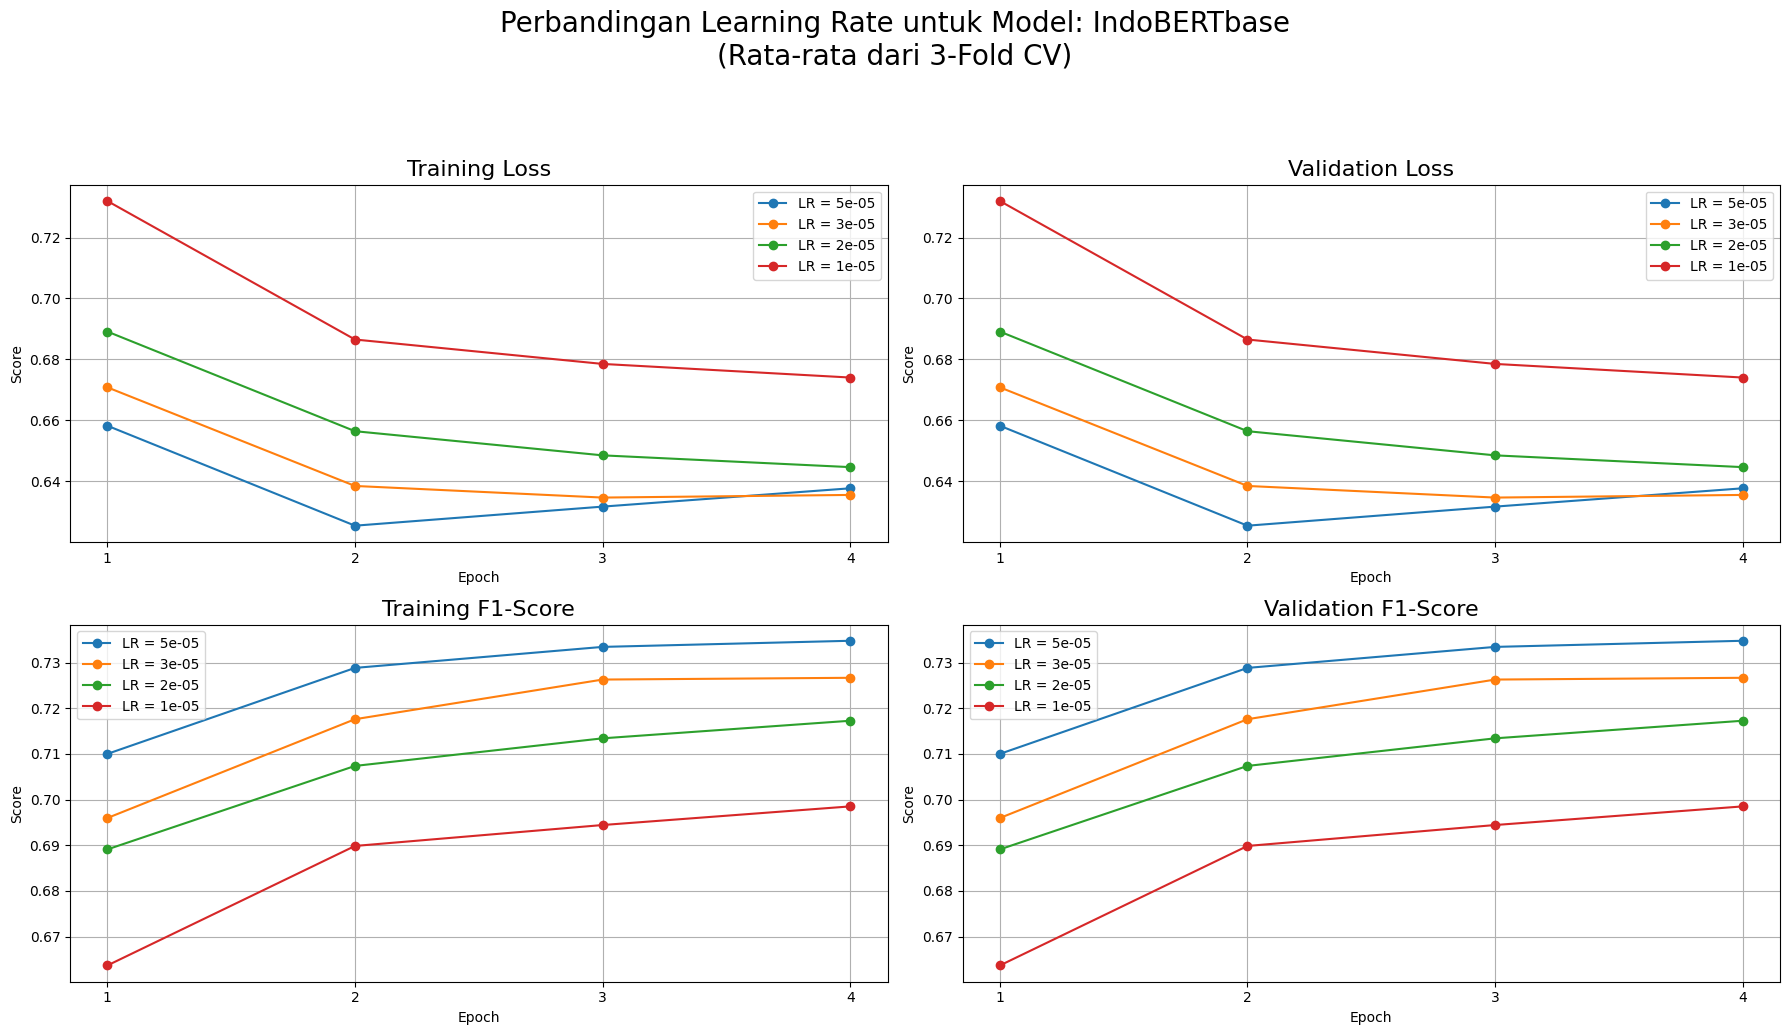

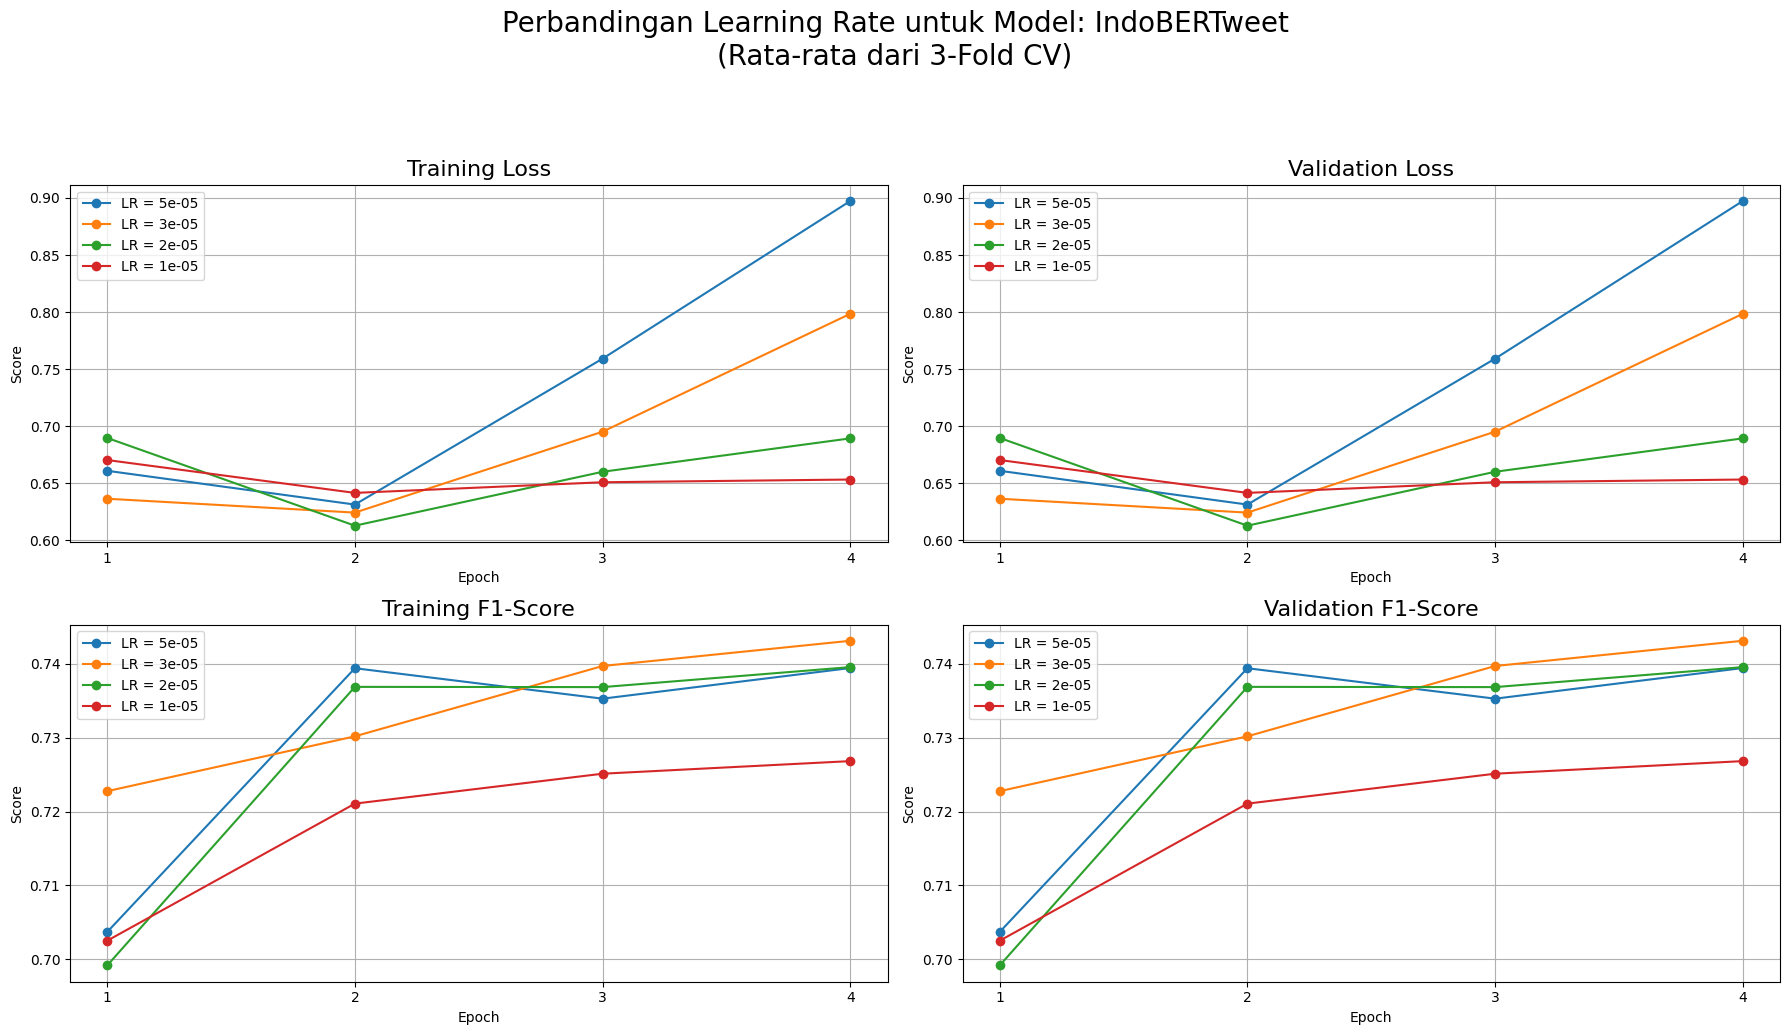

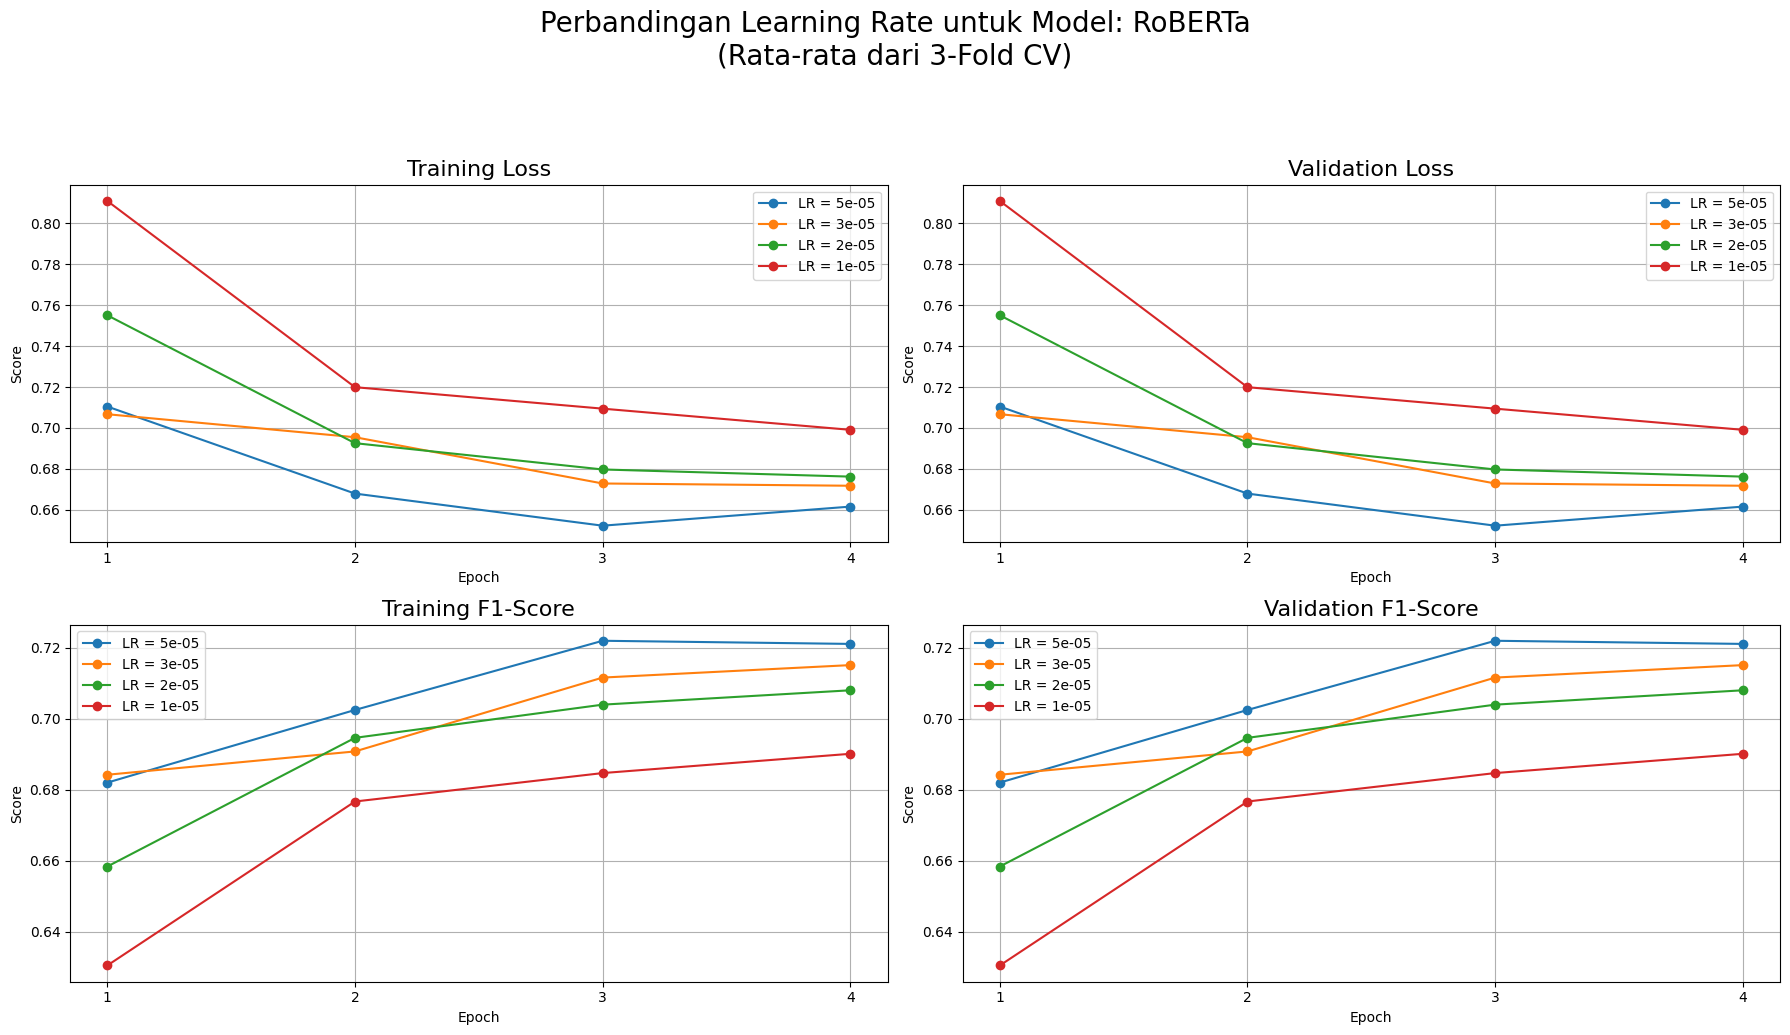

In [11]:
def plot_lr_comparison(model_name, lr_histories_dict):
    """Membuat plot perbandingan kurva belajar untuk berbagai LR pada satu model."""
    
    metrics_to_plot = ['loss', 'f1']
    metric_titles = ['Loss', 'F1-Score']
    
    fig, axes = plt.subplots(len(metrics_to_plot), 2, figsize=(18, len(metrics_to_plot) * 5))
    fig.suptitle(f'Perbandingan Learning Rate untuk Model: {model_name}\n(Rata-rata dari {N_SPLITS}-Fold CV)', fontsize=20, y=1.03)

    for i, metric in enumerate(metrics_to_plot):
        # Plot untuk Training
        ax_train = axes[i, 0]
        ax_train.set_title(f'Training {metric_titles[i]}', fontsize=16)
        # Plot untuk Validasi
        ax_val = axes[i, 1]
        ax_val.set_title(f'Validation {metric_titles[i]}', fontsize=16)

        for lr, history in lr_histories_dict.items():
            epochs_range = range(1, len(history[f'train_{metric}']) + 1)
            ax_train.plot(epochs_range, history[f'train_{metric}'], 'o-', label=f'LR = {lr}')
            ax_val.plot(epochs_range, history[f'val_{metric}'], 'o-', label=f'LR = {lr}')

        ax_train.set_xlabel('Epoch'); ax_train.set_ylabel('Score'); ax_train.legend(); ax_train.grid(True)
        ax_val.set_xlabel('Epoch'); ax_val.set_ylabel('Score'); ax_val.legend(); ax_val.grid(True)
        ax_train.set_xticks(epochs_range); ax_val.set_xticks(epochs_range)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Buat plot untuk setiap model yang diuji
for model_alias, lr_histories in all_histories.items():
    plot_lr_comparison(model_alias, lr_histories)